In [1]:
# Imports
import numpy as np
import os
from utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 각자의 데이터 경로로 수정 
X_train, labels_train, list_ch_train = read_data(data_path="UCI HAR Dataset/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="UCI HAR Dataset/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

/home/qinxie/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

As in many CNN architectures, the deeper the layers get, the higher the number of filters become.

In [8]:
class  New_CNN:

    def __init__(self, name):
        self.name = name

    def __call__(self, X, reuse=False):

        with tf.variable_scope(self.name) as scope:

            if reuse:
                scope.reuse_variables()

            with tf.variable_scope('layer0'):
                X_img = X

            # Convolutional Layer #1 
            with tf.variable_scope('layer1'):
                # (batch, 128, 9) --> (batch, 128, 18)
                conv1 = tf.layers.conv1d(inputs=X_img, filters=18, kernel_size=2,
                                         padding='same', activation = tf.nn.relu, use_bias=False)

            # Convolutional Layer #2 
            with tf.variable_scope('layer2'):
                # (batch, 64, 18) --> (batch, 128, 36)
                conv2 = tf.layers.conv1d(inputs=conv1, filters=36, kernel_size=2,  
                                         padding='same', activation = tf.nn.relu, use_bias=False)

            # Convolutional Layer #3 
            with tf.variable_scope('layer3'):
                # (batch, 32, 36) --> (batch, 128, 72)
                conv3 = tf.layers.conv1d(inputs=conv2, filters=72, kernel_size=2, 
                                         padding='same', activation = tf.nn.relu, use_bias=False)


            # Dense Layer with Relu
            with tf.variable_scope('layer4'):
                # (batch, 16, 72) --> (batch, 128, 144)
                conv4 = tf.layers.conv1d(inputs=conv3, filters=144, kernel_size=2, 
                                         padding='same', activation = tf.nn.relu, use_bias=False)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            with tf.variable_scope('layer5'):
                # Flatten and add dropout
                flat = tf.reshape(conv4, (-1, 128*144))
    
                # Predictions
                logits = tf.layers.dense(flat, n_classes, use_bias=False)
                prediction = tf.nn.softmax(logits)

        return [X_img, conv1, conv2, conv3,conv4, flat, prediction], logits
    
    @property
    def vars(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
    
    
    

In [9]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    
    new_CNN = New_CNN('CNN')
    
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [10]:
with graph.as_default():
    
    activations, logits = new_CNN(inputs_)
    
    tf.add_to_collection('DTD', inputs_)
    
    for activation in activations:
        tf.add_to_collection('DTD', activation)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True    
    
with tf.Session(config=config,graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 100 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

('Epoch: 11/1000', 'Iteration: 100', 'Train loss: 0.471650', 'Train acc: 0.866667')
('Epoch: 11/1000', 'Iteration: 100', 'Validation loss: 0.498943', 'Validation acc: 0.851111')
('Epoch: 22/1000', 'Iteration: 200', 'Train loss: 0.232768', 'Train acc: 0.940000')
('Epoch: 22/1000', 'Iteration: 200', 'Validation loss: 0.251696', 'Validation acc: 0.912778')
('Epoch: 33/1000', 'Iteration: 300', 'Train loss: 0.179839', 'Train acc: 0.923333')
('Epoch: 33/1000', 'Iteration: 300', 'Validation loss: 0.187988', 'Validation acc: 0.930556')
('Epoch: 44/1000', 'Iteration: 400', 'Train loss: 0.153316', 'Train acc: 0.936667')
('Epoch: 44/1000', 'Iteration: 400', 'Validation loss: 0.161562', 'Validation acc: 0.937778')
('Epoch: 55/1000', 'Iteration: 500', 'Train loss: 0.115034', 'Train acc: 0.958333')
('Epoch: 55/1000', 'Iteration: 500', 'Validation loss: 0.146306', 'Validation acc: 0.941111')
('Epoch: 66/1000', 'Iteration: 600', 'Train loss: 0.107070', 'Train acc: 0.953333')
('Epoch: 66/1000', 'Iterat

('Epoch: 522/1000', 'Iteration: 4700', 'Train loss: 0.004569', 'Train acc: 1.000000')
('Epoch: 522/1000', 'Iteration: 4700', 'Validation loss: 0.178549', 'Validation acc: 0.974444')
('Epoch: 533/1000', 'Iteration: 4800', 'Train loss: 0.010435', 'Train acc: 1.000000')
('Epoch: 533/1000', 'Iteration: 4800', 'Validation loss: 0.183920', 'Validation acc: 0.972778')
('Epoch: 544/1000', 'Iteration: 4900', 'Train loss: 0.010996', 'Train acc: 1.000000')
('Epoch: 544/1000', 'Iteration: 4900', 'Validation loss: 0.189304', 'Validation acc: 0.972778')
('Epoch: 555/1000', 'Iteration: 5000', 'Train loss: 0.006916', 'Train acc: 1.000000')
('Epoch: 555/1000', 'Iteration: 5000', 'Validation loss: 0.194603', 'Validation acc: 0.973889')
('Epoch: 566/1000', 'Iteration: 5100', 'Train loss: 0.004131', 'Train acc: 1.000000')
('Epoch: 566/1000', 'Iteration: 5100', 'Validation loss: 0.201271', 'Validation acc: 0.974444')
('Epoch: 577/1000', 'Iteration: 5200', 'Train loss: 0.004070', 'Train acc: 1.000000')
('Ep

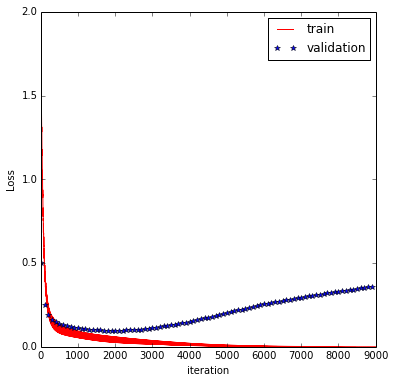

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-')
plt.plot(t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

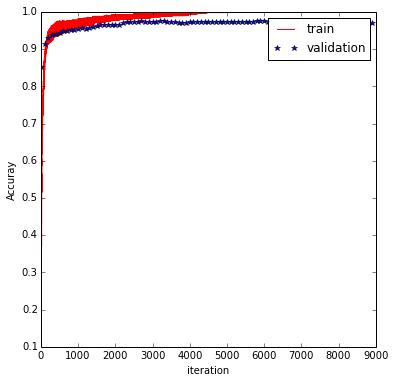

In [14]:

# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
test_acc = []

#         config = tf.ConfigProto(device_count={'GPU': 0})
config = tf.ConfigProto()
#         config.gpu_options.visible_device_list= '0' #only see the gpu 1
config.gpu_options.allow_growth = True   
with tf.Session(config=config,graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.862917


In [16]:
tf.reset_default_graph()
#         config = tf.ConfigProto(device_count={'GPU': 0})
config = tf.ConfigProto()
#         config.gpu_options.visible_device_list= '0' #only see the gpu 1
config.gpu_options.allow_growth = True   
sess = tf.InteractiveSession(config=config)

new_saver = tf.train.import_meta_graph('checkpoints-cnn/har.ckpt.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoints-cnn'))
# weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
# biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*bias.*')

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
activations = tf.get_collection('DTD')
X = activations[0]

INFO:tensorflow:Restoring parameters from ./checkpoints-cnn/har.ckpt


In [17]:
X

<tf.Tensor 'inputs:0' shape=(?, 128, 9) dtype=float32>

In [18]:
activations

[<tf.Tensor 'inputs:0' shape=(?, 128, 9) dtype=float32>,
 <tf.Tensor 'inputs:0' shape=(?, 128, 9) dtype=float32>,
 <tf.Tensor 'CNN/layer1/conv1d/Relu:0' shape=(?, 128, 18) dtype=float32>,
 <tf.Tensor 'CNN/layer2/conv1d/Relu:0' shape=(?, 128, 36) dtype=float32>,
 <tf.Tensor 'CNN/layer3/conv1d/Relu:0' shape=(?, 128, 72) dtype=float32>,
 <tf.Tensor 'CNN/layer4/conv1d/Relu:0' shape=(?, 128, 144) dtype=float32>,
 <tf.Tensor 'CNN/layer5/Reshape:0' shape=(?, 18432) dtype=float32>,
 <tf.Tensor 'CNN/layer5/Softmax:0' shape=(?, 6) dtype=float32>]

In [19]:
weights

[<tf.Variable 'CNN/layer1/conv1d/kernel:0' shape=(2, 9, 18) dtype=float32_ref>,
 <tf.Variable 'CNN/layer2/conv1d/kernel:0' shape=(2, 18, 36) dtype=float32_ref>,
 <tf.Variable 'CNN/layer3/conv1d/kernel:0' shape=(2, 36, 72) dtype=float32_ref>,
 <tf.Variable 'CNN/layer4/conv1d/kernel:0' shape=(2, 72, 144) dtype=float32_ref>,
 <tf.Variable 'CNN/layer5/dense/kernel:0' shape=(18432, 6) dtype=float32_ref>]

In [20]:
from tensorflow.python.ops import nn_ops, gen_nn_ops
from tensorflow.python.layers import pooling
class Taylor:

    def __init__(self, activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, name):

        self.last_ind = len(activations)
        for op in activations[::-1]:
            self.last_ind -= 1
            if any([word in op.name for word in ['conv', 'pooling', 'dense']]):
                break

        self.activations = activations
        self.weights = weights
        self.conv_ksize = conv_ksize
        self.pool_ksize = pool_ksize
        self.conv_strides = conv_strides
        self.pool_strides = pool_strides
        self.name = name
    
    def __call__(self, logit):
        with tf.name_scope(self.name):
            Rs = []
            j = 0

            for i in range(len(self.activations) - 2):

                if i is self.last_ind:

                    if 'conv' in self.activations[i].name.lower():
                        Rs.append(self.backprop_conv_input(self.activations[i + 1], self.weights[j], Rs[-1], self.conv_strides))
                    else:
                        Rs.append(self.backprop_dense_input(self.activations[i + 1], self.weights[j], Rs[-1]))

                    continue

                if i is 0:
                    Rs.append(self.activations[i][:,logit,None])
                    Rs.append(self.backprop_dense(self.activations[i + 1], self.weights[j][:,logit,None], Rs[-1]))
                    j += 1

                    continue

                elif 'dense' in self.activations[i].name.lower():
                    Rs.append(self.backprop_dense(self.activations[i + 1], self.weights[j], Rs[-1]))
                    j += 1
                elif 'reshape' in self.activations[i].name.lower():
                    shape = self.activations[i + 1].get_shape().as_list()
                    shape[0] = -1
                    Rs.append(tf.reshape(Rs[-1], shape))
                elif 'conv' in self.activations[i].name.lower():
                    Rs.append(self.backprop_conv(self.activations[i + 1], self.weights[j], Rs[-1], self.conv_strides))
                    j += 1
                else:
                    raise Error('Unknown operation.')

            return Rs[-1]

    def backprop_conv(self, activation, kernel, relevance, strides, padding='SAME'):
        W_p = tf.maximum(0., kernel)
        z = nn_ops.conv1d(activation, W_p, strides, padding) + 1e-10
        s = relevance / z
        print(tf.shape(s))
        c = nn_ops.conv1d_transpose(s, W_p, tf.shape(activation), strides, padding)
        return activation * c

    def backprop_dense(self, activation, kernel, relevance):
        W_p = tf.maximum(0., kernel)
        z = tf.matmul(activation, W_p) + 1e-10
        s = relevance / z
        c = tf.matmul(s, tf.transpose(W_p))
        return activation * c

    def backprop_conv_input(self, X, kernel, relevance, strides, padding='SAME', lowest=0., highest=1.):
        W_p = tf.maximum(0., kernel)
        W_n = tf.minimum(0., kernel)

        L = tf.ones_like(X, tf.float32) * lowest
        H = tf.ones_like(X, tf.float32) * highest

        z_o = nn_ops.conv1d(X, kernel, strides, padding)
        z_p = nn_ops.conv1d(L, W_p, strides, padding)
        z_n = nn_ops.conv1d(H, W_n, strides, padding)

        z = z_o - z_p - z_n + 1e-10
        s = relevance / z

        c_o = nn_ops.conv1d_transpose(s, kernel, tf.shape(X), strides, padding)
        c_p = nn_ops.conv1d_transpose(s, W_p, tf.shape(X), strides, padding)
        c_n = nn_ops.conv1d_transpose(s, W_n, tf.shape(X), strides, padding)

        return X * c_o - L * c_p - H * c_n

    def backprop_dense_input(self, X, kernel, relevance, lowest=0., highest=1.):
        W_p = tf.maximum(0., kernel)
        W_n = tf.minimum(0., kernel)

        L = tf.ones_like(X, tf.float32) * lowest
        H = tf.ones_like(X, tf.float32) * highest

        z_o = tf.matmul(X, kernel)
        z_p = tf.matmul(L, W_p)
        z_n = tf.matmul(H, W_n)

        z = z_o - z_p - z_n + 1e-10
        s = relevance / z

        c_o = tf.matmul(s, tf.transpose(kernel))
        c_p = tf.matmul(s, tf.transpose(W_p))
        c_n = tf.matmul(s, tf.transpose(W_n))

        return X * c_o - L * c_p - H * c_n

In [21]:
conv_ksize = 2
pool_ksize = 2
conv_strides = 1
pool_strides = 2

weights.reverse()
activations.reverse()

In [22]:
taylor = Taylor(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'Taylor')

In [23]:
Rs = []
for i in range(6):
    Rs.append(taylor(i))

Tensor("Taylor/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_1/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_1/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_1/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_2/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_2/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_2/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_3/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_3/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_3/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_4/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_4/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_4/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_5/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_5/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_5/Shape_4:0", shape=(3,), dtype=int32)


In [24]:
sample_imgs = []
for i in range(6):
    sample_imgs.append(X_tr[np.argmax(y_tr, axis=1) == i][10])

In [25]:
imgs = []
for i in range(6):
    imgs.append(sess.run(Rs[i], feed_dict={X: sample_imgs[i][None,:]}))

In [26]:
imgs = np.squeeze(imgs)
sample_imgs = np.squeeze(sample_imgs)

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING

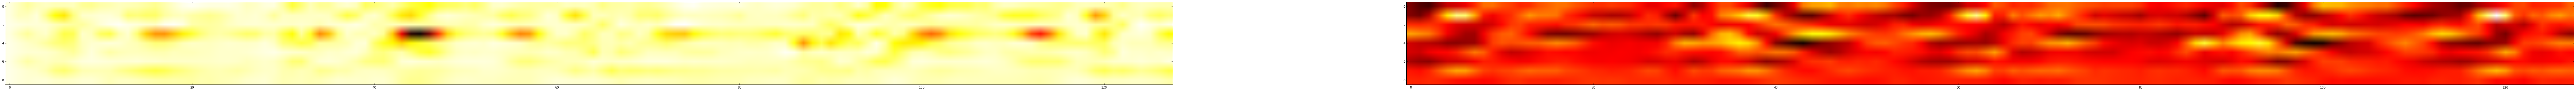

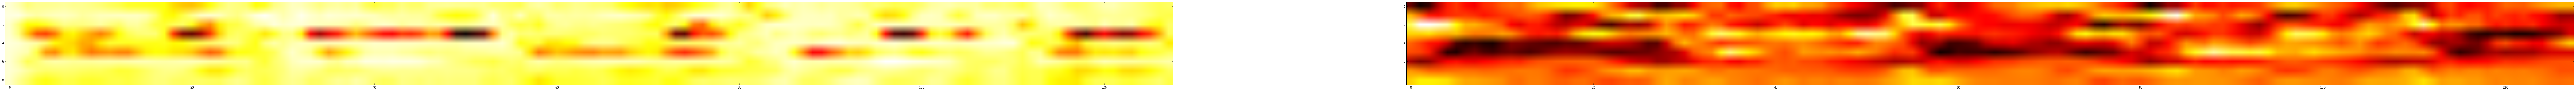

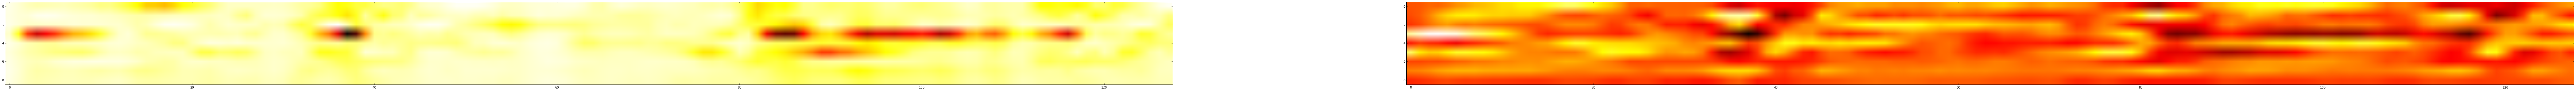

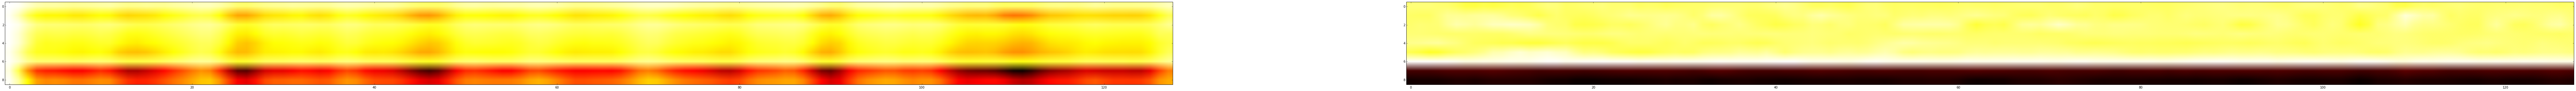

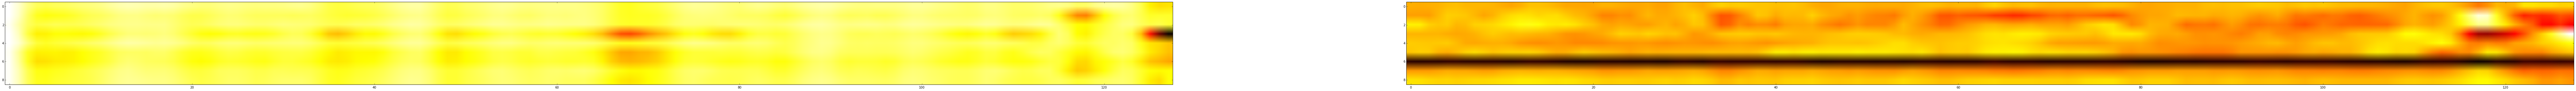

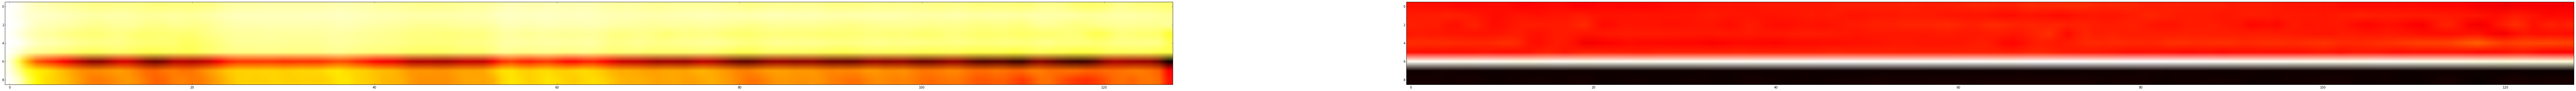

In [27]:
for i in range(6):
    plt.figure(figsize=(150,150))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(imgs[i]), cmap='hot_r')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(sample_imgs[i]), cmap='hot_r')